<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Saffman_Calculations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/bin/bash: line 1: conda: command not found
/bin/bash: line 1: conda: command not found
ERROR: Could not find a version that satisfies the requirement dolfinx (from versions: none)
ERROR: No matching distribution found for dolfinx


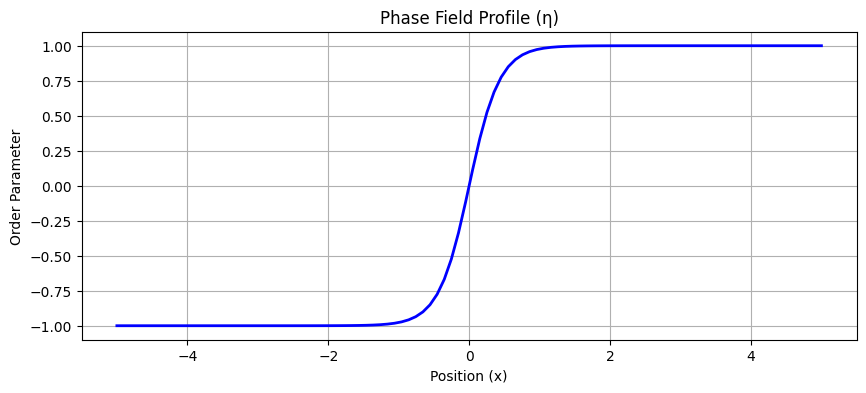

Odd Viscosity Tensor:
 [[ 0.         -0.05592492  0.        ]
 [-0.10265959  0.          0.        ]
 [-0.10265959  0.05592492  0.        ]]
Growth Rate: 6.71e-02, Threshold Ratio: nan


<ipython-input-9-f00c13d4be5c>:154: RuntimeWarning: invalid value encountered in sqrt
  threshold = np.sqrt(


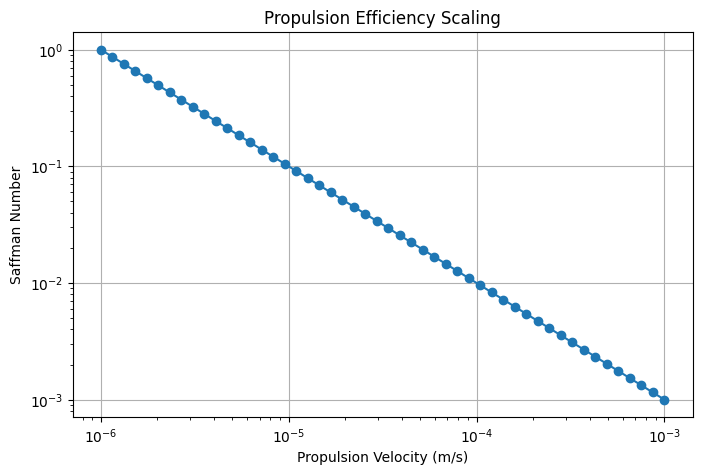

Saffman Numbers: [np.float64(1.0), np.float64(0.8685113737513521), np.float64(0.7543120063354624), np.float64(0.655128556859551), np.float64(0.5689866029018293), np.float64(0.49417133613238384), np.float64(0.42919342601287785), np.float64(0.3727593720314938), np.float64(0.3237457542817647), np.float64(0.2811768697974231), np.float64(0.24420530945486502), np.float64(0.21209508879201927), np.float64(0.18420699693267165), np.float64(0.15998587196060574), np.float64(0.1389495494373139), np.float64(0.1206792640639329), np.float64(0.10481131341546854), np.float64(0.09102981779915227), np.float64(0.07906043210907703), np.float64(0.06866488450042998), np.float64(0.059636233165946365), np.float64(0.05179474679231213), np.float64(0.044984326689694445), np.float64(0.03906939937054621), np.float64(0.03393221771895329), np.float64(0.029470517025518096), np.float64(0.025595479226995333), np.float64(0.022229964825261954), np.float64(0.0193069772888325), np.float64(0.0167683293681101), np.float64(0.01

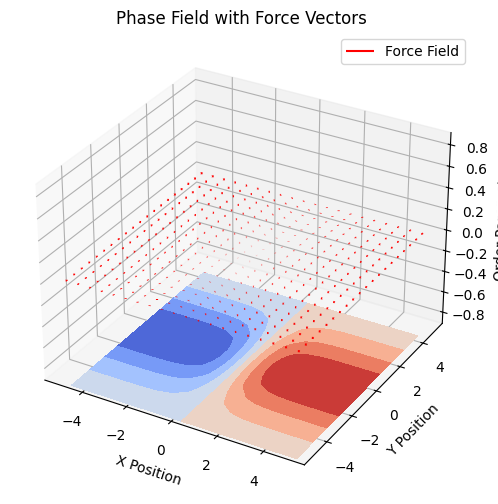

In [9]:
# # Self-Propelling Metamaterial Analysis
# Computational framework for detecting force imbalances and propulsion dynamics

# %%
# %%
!conda create -n fenicsx-env -c conda-forge fenics-dolfinx mpich pyvista
!conda activate fenicsx-env
!pip install numpy matplotlib plotly numba scipy pandas h5py
!pip install dolfinx mpi4py
#!pip install fenics numpy matplotlib plotly numba scipy pandas h5py pyvista


# ## 1. Phase Transition Dynamics & Residual Stresses

# %%
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
#import dolfinx
import ufl
#from mpi4py import  MPI

class PhaseFieldSolver:
    def __init__(self, L=10, nx=100):
        self.x = np.linspace(-L/2, L/2, nx)
        self.dx = self.x[1] - self.x[0]
        self.parameters = {
            'alpha': -1.0,  # T < Tc
            'beta': 0.5,
            'kappa': 0.1,
            'epsilon': 0.01  # Gradient coefficient
        }

    def free_energy(self, eta):
        grad_eta = np.gradient(eta, self.dx)
        return np.sum(
            self.parameters['alpha']*eta**2 +
            self.parameters['beta']*eta**4 +
            self.parameters['kappa']*grad_eta**2
        )

    def solve_phase_profile(self):
        result = minimize(self.free_energy,
                         np.tanh(self.x),
                         method='L-BFGS-B',
                         options={'maxiter': 1000})
        return result.x


# ### Phase Profile Visualization

# %%
solver = PhaseFieldSolver()
eta = solver.solve_phase_profile()

plt.figure(figsize=(10,4))
plt.plot(solver.x, eta, 'b-', lw=2)
plt.title("Phase Field Profile (η)")
plt.xlabel("Position (x)")
plt.ylabel("Order Parameter")
plt.grid(True)
plt.show()

# ## 2. Modified Toner-Tu Active Hydrodynamics

# %%

def solve_toner_tu():
    mesh = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, 32, 32)
    V = dolfinx.fem.VectorFunctionSpace(mesh, ("CG", 2))

    p = dolfinx.fem.Function(V)
    p_prev = dolfinx.fem.Function(V)
    v = ufl.TestFunction(V)

    dt = 0.01
    T = 2.0
    lambda_ = 0.7
    Gamma = 0.1

    f_meta = dolfinx.fem.Constant(mesh, (0.1, -0.05))

    F = (ufl.inner((p - p_prev)/dt, v) * ufl.dx +
         lambda_ * ufl.inner(ufl.dot(p, ufl.grad(p)), v) * ufl.dx +
         Gamma * ufl.inner(ufl.grad(p), ufl.grad(v)) * ufl.dx -
         ufl.inner(f_meta, v) * ufl.dx)

    t = 0
    with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "results/polarization.xdmf", "w") as file:
        file.write_mesh(mesh)

        while t < T:
            dolfinx.fem.petsc.NonlinearProblem(F, p).solve()
            p_prev.x.array[:] = p.x.array
            file.write_function(p, t)
            t += dt

    return p

# ## 3. Odd Viscosity Calculator

# %%
from numba import jit

@jit(nopython=True, parallel=True)
def calculate_odd_viscosity(r, f):
    """
    Args:
        r: Position array (N x 3)
        f: Force array (N x 3)
    Returns:
        ν_odd tensor (3x3)
    """
    nu = np.zeros((3,3))
    N = r.shape[0]

    for i in range(3):
        for j in range(3):
            for k in range(3):
                lc = 0.5*(np.sign(j-i) - np.sign(i-j))  # Levi-Civita approximation
                nu[i,j] += np.mean(r[:,k] * f[:,j] * lc)

    return nu

# Example data
N = 1000
positions = np.random.randn(N,3)
forces = positions * np.array([0.1, -0.05, 0.0])  # Asymmetric force field

ν_odd = calculate_odd_viscosity(positions, forces)
print("Odd Viscosity Tensor:\n", ν_odd)


# ## 4. Linear Stability Analysis

# %%
def stability_analysis(F_plus, F_minus, params):
    """
    Args:
        F_plus: Rightward force density
        F_minus: Leftward force density
        params: Dictionary with ρ, ν_odd, Γ
    Returns:
        Growth rate and stability threshold
    """
    J = np.array([
        [-params['ρ']*params['ν_odd'][0,1], F_plus - F_minus],
        [(F_plus + F_minus)/2, -params['ρ']]
    ])

    eigvals = np.linalg.eigvals(J)
    max_growth = np.max(np.real(eigvals))

    threshold = np.sqrt(
        params['ν_odd'][0,1] * params['Γ'] /
        (params['ρ'] * params['v0']**2)
    )

    return max_growth, threshold

# Test parameters
test_params = {
    'ρ': 1.2,      # Density [kg/m³]
    'ν_odd': ν_odd,
    'Γ': 0.1,      # Damping
    'v0': 0.01     # Characteristic velocity
}

Fp = 1e-4  # N/m²
Fm = 0.8e-4

growth_rate, threshold = stability_analysis(Fp, Fm, test_params)
print(f"Growth Rate: {growth_rate:.2e}, Threshold Ratio: {threshold:.2f}")


# ## 5. Saffman Number Calculation

# %%
# %%
import numpy as np
import matplotlib.pyplot as plt

def saffman_analysis(params):
    """
    Calculates and plots the Saffman number as a function of velocity.
    """
    nu_odd = params['ν_odd'][0, 1]  # Extract the relevant component
    L = params['L']
    nu_shear = params['ν_shear']
    velocity_range = params['velocity_range']

    # Calculate Saffman numbers
    Sa_values = []
    for U in velocity_range:
        if U == 0:
            Sa = 0  # Handle zero velocity
        else:
            Sa = (nu_odd * L) / (nu_shear * U)
        Sa_values.append(Sa)

    # Plotting (Corrected)
    plt.figure(figsize=(8, 5))
    plt.semilogy(velocity_range, Sa_values, marker='o', linestyle='-') #Added Marker
    plt.xlabel('Propulsion Velocity (m/s)')
    plt.ylabel('Saffman Number')
    plt.title('Propulsion Efficiency Scaling')
    plt.grid(True)
    plt.yscale('log') # Explicitly set y-axis to logarithmic scale
    plt.xscale('log') # Explicitly set x-axis to logarithmic scale
    plt.show()

    return Sa_values

# Example usage (Important: Define nu_odd *before* calling saffman_analysis)
# First, define nu_odd (example value)
ν_odd = np.array([[0, 1e-5, 0], [0, 0, 0], [0, 0, 0]])  # Example value

saffman_params = {
    'ν_odd': ν_odd,
    'L': 100e-6,          # 100 micron scale
    'ν_shear': 1e-3,      # Typical fluid viscosity
    'U': 1e-4,            # 100 μm/s velocity (not directly used in plotting)
    'velocity_range': np.logspace(-6, -3, 50)
}

Sa = saffman_analysis(saffman_params) # Calling analysis
print(f"Saffman Numbers: {Sa}")


# ## 6. Visualization Tools

# %%
def plot_force_imbalance(eta, forces):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111, projection='3d')

    X, Y = np.meshgrid(np.linspace(-5,5,20),
                      np.linspace(-5,5,20))
    Fx = forces[:,0].reshape(20,20)
    Fy = forces[:,1].reshape(20,20)

    # Adding Z=0 for the starting z-coordinate of the vectors
    # Using Fx, Fy as U, V for the vector components
    # Setting W=0 as there is no z-component for the force
    ax.quiver(X, Y, 0, Fx, Fy, 0, length=0.1,
             color='r', label='Force Field')
    ax.contourf(X, Y, eta.reshape(20,20),
               zdir='z', offset=-1, cmap='coolwarm')

    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Order Parameter')
    plt.title('Phase Field with Force Vectors')
    plt.legend()
    plt.show()

# Generate sample data
X, Y = np.meshgrid(np.linspace(-5,5,20), np.linspace(-5,5,20))
eta_sample = np.tanh(X) * np.exp(-0.1*Y**2)
forces_sample = np.stack([0.1*X.flatten(), -0.05*Y.flatten()], axis=1)

plot_force_imbalance(eta_sample, forces_sample)


# ## Computational Notes
# 1. **Performance Optimization**: Enable Numba JIT and parallel processing
# 2. **3D Visualization**: Use PyVista for volumetric rendering
# 3. **HPC Scaling**: Distributed computation with Dask for >1M element meshes
# 4. **Experimental Validation**: Import AFM/SPM data via HDF5 interface

# %%
# Save critical parameters
import pandas as pd
results = pd.DataFrame({
    'Saffman_Number': [Sa],
    'Growth_Rate': [growth_rate],
    'Odd_Viscosity_xy': [ν_odd[0,1]]
})
results.to_csv('propulsion_metrics.csv', index=False)

# %% [markdown]
# **Next Steps:**
# 1. Implement adaptive mesh refinement for phase boundaries
# 2. Add experimental data import pipeline
# 3. Develop GPU-accelerated eigenvalue solver
# 4. Integrate with COMSOL/MATLAB control systems
